In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import IPython.display as ipd
import pandas as pd
import numpy as np
import seaborn as sns
import librosa
import soundfile as sf
import re
import scipy
import torch
import matplotlib.pyplot as plt
import nnAudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import gc
import seaborn as sns

from glob import glob
from tqdm import tqdm
from nnAudio.features.mel import MelSpectrogram
from torchaudio.transforms import AmplitudeToDB
from transformers import (
    AutoTokenizer, AutoFeatureExtractor, AutoModelForCTC, 
    AutoProcessor, Wav2Vec2Model, HubertForCTC, 
    HubertModel, Data2VecAudioForCTC, Data2VecAudioModel,
    AutoModelForAudioXVector
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
DEVICE = "cuda"

# Agenda
1. [Why do we need SSL representations?](#Why_do_we_need_SSL_representations)
2. [Moving from librosa to torchaudio/nnAudio](#TorchAudio)
3. [SSL Audio NNs](#SSL_Audio_NNs)
4. [SSL Features for Speaker Classification](#SSL_Features_for_Speaker_Classification)
5. [Homework](#Homework)
6. [Optional Additional Task](#Optional_Additional_Task)

<a id='Why_do_we_need_SSL_representations'></a>
# Why do we need SSL representations?

Our main goal is to train the better model (in terms of metrics) using a smaller amount of training data.

HOWEVER, accumulating lots of unlabeled data is MUCH easier than labeling even a tiny amount of data.

![unlabaled_data](images/unlabaled_data.png)

![data_labeling](images/data_labeling.png)

How can we benefit from lots of unlabeled data?

![transfer_learning](images/transfer_learning.png)

![weak_supervision](images/weak_supervision.png)

![ssl_features](images/ssl_features.png)

<a id='TorchAudio'></a>
# Moving from `librosa` to `torchaudio`/`nnAudio`?

In [4]:
# Refactored from https://chat.openai.com/share/e/52f6acc9-152d-4a99-b874-86998ad8fcc7
def load_and_process_audio(paths, sample_rate=None):
    # Load and resample audio files
    audios = []
    max_length = 0
    for path in tqdm(paths):
        audio, sr = librosa.load(path, sr=sample_rate)
        max_length = max(max_length, len(audio))
        audios.append(audio)

    # Pad audios to have the same length and stack them into a batch
    batched_audio = torch.zeros(len(audios), max_length)  # Assuming mono audio files
    padding_masks = torch.zeros(len(audios), max_length)
    for i, audio in enumerate(audios):
        length = len(audio)
        batched_audio[i, :length] = torch.from_numpy(audio)
        padding_masks[i, :length] = 1  # Mark non-padded areas as 1

    return batched_audio, padding_masks

In [5]:
wave_pathes = glob(
    "../../data/VCTK-Corpus/VCTK-Corpus/wav48/*/*.wav", recursive=True
)
# In case of Windows
wave_pathes = [wave_path.replace('\\', '/') for wave_path in wave_pathes]

speaker2pathes = dict()
for speaker in set([wave_path.split("/")[-2] for wave_path in wave_pathes]):
    speaker2pathes[speaker] = [
        wave_path for wave_path in wave_pathes if wave_path.split("/")[-2] == speaker
    ]

In [6]:
# Ignore it :) I want to pick "hard" line on the first place
speaker2pathes["p279"] = (
    [speaker2pathes["p279"].pop(speaker2pathes["p279"].index("../../data/VCTK-Corpus/VCTK-Corpus/wav48/p279/p279_202.wav"))]
    +
    speaker2pathes["p279"]
)

In [7]:
speaker_audio, speaker_pad_mask = load_and_process_audio(speaker2pathes["p279"])

100%|██████████| 405/405 [00:00<00:00, 686.16it/s]


In [8]:
speaker_audio.shape, speaker_pad_mask.shape

(torch.Size([405, 456951]), torch.Size([405, 456951]))

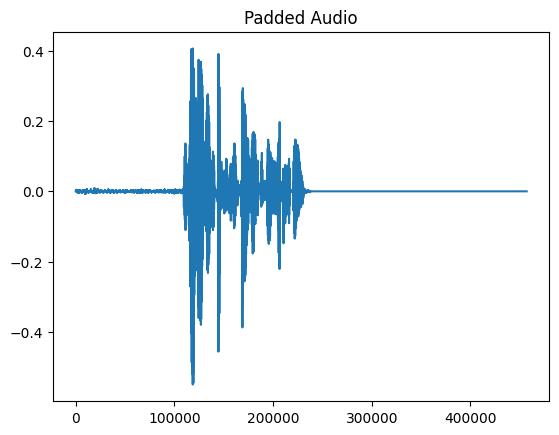

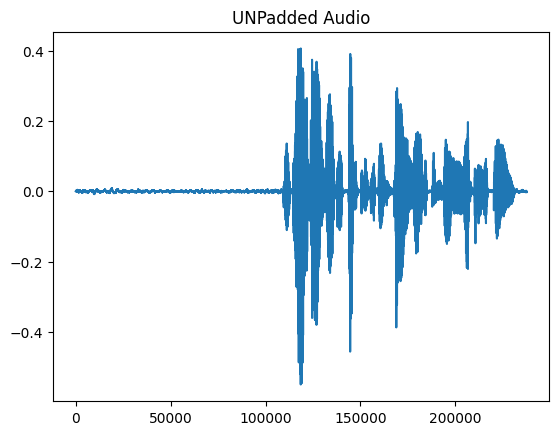

In [9]:
plt.title("Padded Audio")
plt.plot(speaker_audio[0])
plt.show()
plt.title("UNPadded Audio")
plt.plot(speaker_audio[0][speaker_pad_mask[0].bool()])
plt.show()

> <font style="color:red">**TODO**</font>: Implement "UniversalSlicer", which will be able to cut/pad waves to pre-defined length and batch them. Implement different cutting/padding policies, for example, right/left pad, cut to fixed length or by silence regions (2+ points).

[nnAudio Docs](https://kinwaicheuk.github.io/nnAudio/index.html)

![nnAudio_meme](images/nnAudio_meme.jpg)

In [10]:
spec_layer =  nn.Sequential(
    MelSpectrogram(sr=48000),
    AmplitudeToDB(top_db=80)
)

STFT kernels created, time used = 0.0663 seconds
STFT filter created, time used = 0.0010 seconds
Mel filter created, time used = 0.0010 seconds


In [11]:
speaker_spec_10 = spec_layer(speaker_audio[:10])

In [12]:
speaker_spec_10.shape

torch.Size([10, 128, 893])

In [13]:
def extract_pad_digital_silence_from_spec(input_spec):
    amplitude_sum = input_spec.sum(dim=0)
    pad_start = torch.where(amplitude_sum == amplitude_sum.min())[0].min()
    mask = torch.ones_like(amplitude_sum)
    mask[pad_start:] = 0
    return mask

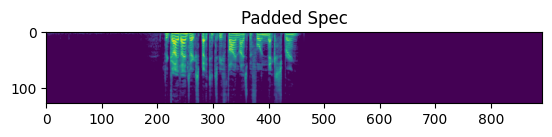

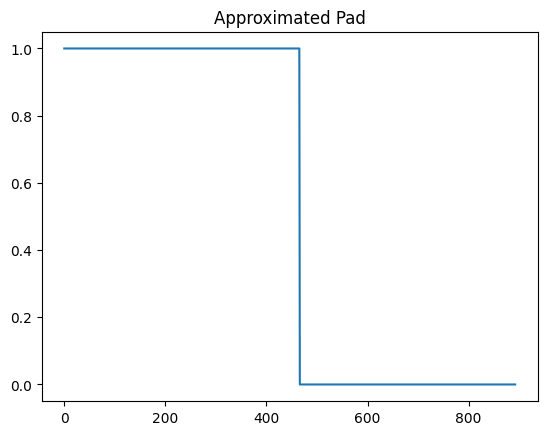

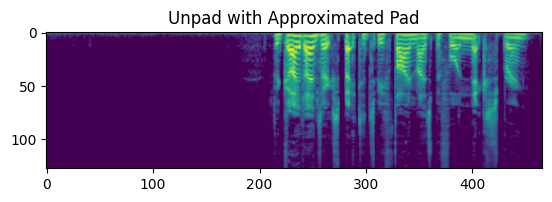

In [14]:
plt.title("Padded Spec")
plt.imshow(speaker_spec_10[0])
plt.show()

approx_pad = extract_pad_digital_silence_from_spec(speaker_spec_10[0])

plt.title("Approximated Pad")
plt.plot(approx_pad)
plt.show()
plt.title("Unpad with Approximated Pad")
plt.imshow(speaker_spec_10[0][:,approx_pad==1])
plt.show()

In [15]:
class Audio2SpecPad(nn.Module):
    def __init__(
        self,
        hop_size=512
    ):
        super().__init__()
        self.maxpool = nn.MaxPool1d(
            kernel_size=hop_size,
            stride=hop_size
        )
    
    def forward(self, audio_pads, time_max_length):
        spec_pads = self.maxpool(audio_pads.unsqueeze(1)).squeeze(1)
        pad = torch.ones(spec_pads.shape[0], time_max_length - spec_pads.shape[-1])
        spec_pads = torch.cat((pad, spec_pads), axis=1)
        return spec_pads
        
audio2spec_pad_layer = Audio2SpecPad()

> <font style="color:red">**TODO**</font>: Rewrite `Audio2SpecPad` and get rid of "hacky pad" (1 point)

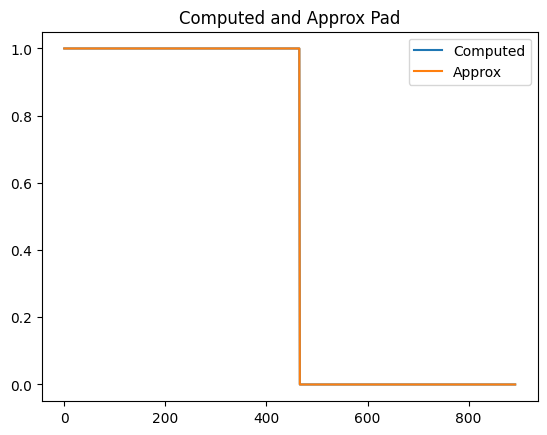

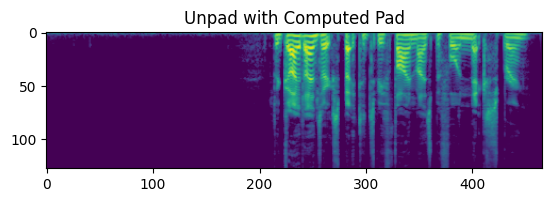

In [16]:
computed_spec_pad = audio2spec_pad_layer(
    speaker_pad_mask[:10], 
    time_max_length=speaker_spec_10.shape[-1]
)

plt.title("Computed and Approx Pad")
plt.plot(computed_spec_pad[0], label="Computed")
plt.plot(approx_pad, label="Approx")
plt.legend()
plt.show()
plt.title("Unpad with Computed Pad")
plt.imshow(speaker_spec_10[0][:,computed_spec_pad[0]==1])
plt.show()

<a id='SSL_Audio_NNs'></a>
# SSL Audio NNs

In [17]:
def parameter_counter(input_model, model_name):
    counter = 0
    for param in input_model.parameters():
        counter += param.shape.numel()
    print(f"{model_name} Parameters Count: {f'{counter/1_000_000:.1f}M'}")

## [Wave2Vec](https://arxiv.org/abs/1904.05862)

Model consists of 2 parts:
- Encoder network $f: X \rightarrow Z$.
- Context network $g: Z \rightarrow C$.

![w2v_logic](images/w2v_logic.png)

The Encoder network produces latent representations, which Context Vector will then predict.

Main ideas:
- Create latent representations containing “averaged for some period” audio information.
- Train Context network, which can “guess” future latent representations.
- Contrastive loss.

![w2v_loss](images/w2v_loss.png)

![w2c_loss_comp](images/w2v_loss_comp.png)

Image taken from [Jonathan Bgn blog](https://jonathanbgn.com/2021/06/29/illustrated-wav2vec.html)


After the model is trained, we can use the output of Encoder network -> Context network ($f(g(\text{audio}))$) as audio representation, which should contain “plenty of phonetic information”.

![w2v_results](images/w2v_results.png)

### Wave2Vec 2.0

Main ideas:
1. They showed that we can learn discrete units from speech without phonetic labels
2. Core of the architecture is transformer encoder
3. Training objective is similar to language modeling objective and adapted for speech

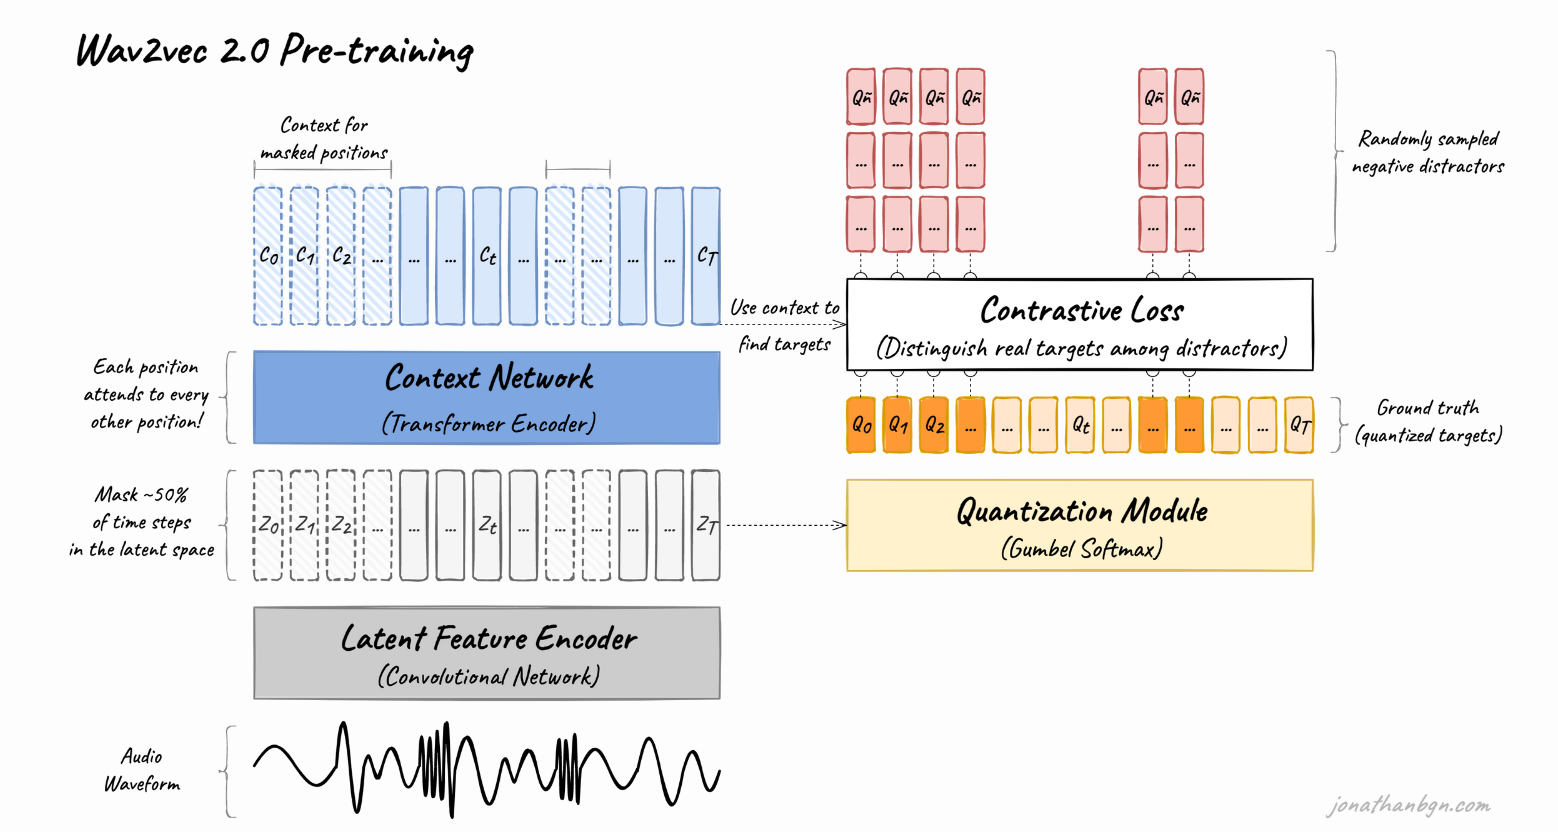
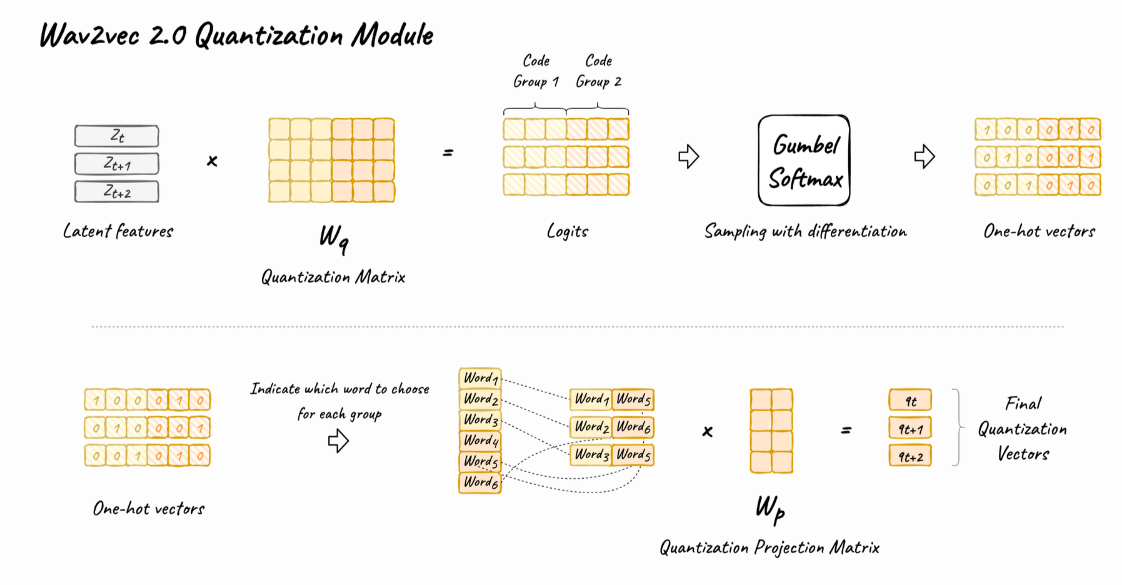

Code example is adopted from official HF example:

- [ASR](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2CTCTokenizer).
- [SSL](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2Model).

In [18]:
model = AutoModelForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained("facebook/wav2vec2-base-960h")
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

In [19]:
type(feature_extractor)

transformers.models.wav2vec2.feature_extraction_wav2vec2.Wav2Vec2FeatureExtractor

In [164]:
parameter_counter(model, "W2V")

W2V Parameters Count: 94.4M


In [165]:
resample_layer = torchaudio.transforms.Resample(
    orig_freq=48000,
    new_freq=16000
)

In [166]:
speaker_audio_10_16k = resample_layer(speaker_audio[:10])

In [167]:
print(f"Time shape decreased {speaker_audio.shape[-1] / speaker_audio_10_16k.shape[-1]} times after resampling")

Time shape decreased 3.0 times after resampling


In [168]:
# Process waves
input_values = feature_extractor([
    el for el in speaker_audio_10_16k.numpy()
], return_tensors="pt").input_values

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


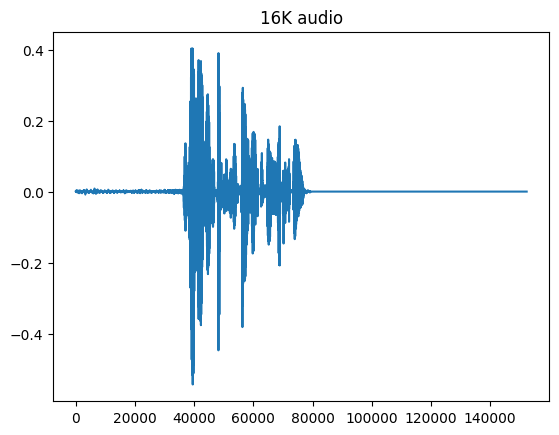

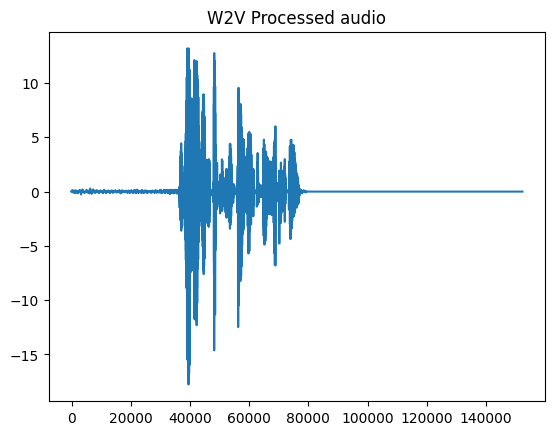

In [36]:
plt.title("16K audio")
plt.plot(speaker_audio_10_16k[0])
plt.show()
plt.title("W2V Processed audio")
plt.plot(input_values[0])
plt.show()

> <font style="color:red">**TODO**</font>: Explore [Wav2Vec2FeatureExtractor](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2FeatureExtractor). Can we rewrite it, so it takes on input batched torch.Tensor ? (1 point)

In [37]:
# Apply Model
with torch.no_grad():
    model_output = model(input_values.cuda())

In [38]:
print(f"Input Shape [B, L]: {input_values.shape}")
print(f"Ouput Shape [B, N_L, C]: {model_output.logits.shape}")

Input Shape [B, L]: torch.Size([10, 152317])
Ouput Shape [B, N_L, C]: torch.Size([10, 475, 32])


I assume that `C` (number of classes) here refer to number of letter in English + a bunch of special symbols. BUT

> **TODO**: Check what does [Wav2Vec2ForCTC("facebook/wav2vec2-base-960h")](https://huggingface.co/facebook/wav2vec2-base-960h) predict ?

In [39]:
# Decode results
pred_ids = torch.argmax(model_output.logits[0], axis=-1)
outputs = tokenizer.decode(pred_ids, output_word_offsets=True)
outputs.text

'THE GYDINES ARE EXPECTED TO BE FINE LINES BEFORE NEXT SPRING'

In [40]:
ipd.Audio(
    data=speaker_audio_10_16k[0],
    rate=16_000
)

In [41]:
!cat {speaker2pathes["p279"][0].replace("wav48", "txt").replace(".wav",".txt")}

The guidelines are expected to be finalised before next spring.


In [42]:
# Free memory 
del model, tokenizer, feature_extractor
torch.cuda.empty_cache()
gc.collect()

3594

But we are not really intersted in ASR now, it is just a cool bonus :)

Lets come back to our SSL features

In [43]:
processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
input_values = processor([
    el for el in speaker_audio_10_16k.numpy()
], sampling_rate=16_000, return_tensors="pt")

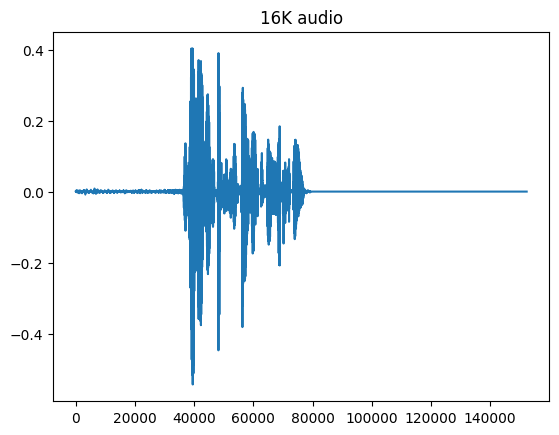

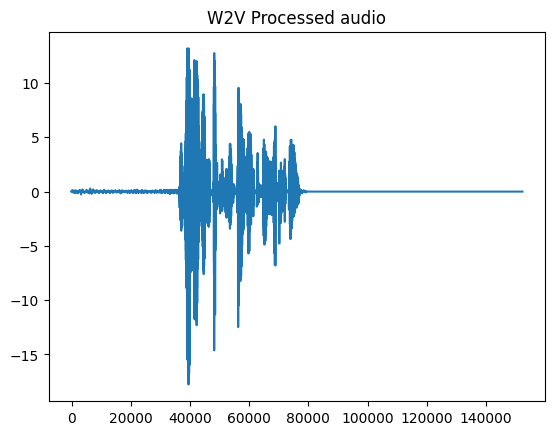

In [45]:
plt.title("16K audio")
plt.plot(speaker_audio_10_16k[0])
plt.show()
plt.title("W2V Processed audio")
plt.plot(input_values.input_values[0])
plt.show()

In [46]:
with torch.no_grad():
    model_output = model(input_values.input_values.cuda())

In [47]:
speaker_w2v_10 = model_output.last_hidden_state.cpu()

In [48]:
print("Reduction Factor (OR Hop Size) from 16K audio:", input_values.input_values.shape[1] / speaker_w2v_10.shape[1])

Reduction Factor (OR Hop Size) from 16K audio: 320.66736842105263


In [49]:
audio2spec_pad_layer = Audio2SpecPad(hop_size=320 * 3)

computed_w2v_pad = audio2spec_pad_layer(
    speaker_pad_mask[:10], 
    time_max_length=speaker_w2v_10.shape[1]
)

In [50]:
speaker_w2v_10.shape

torch.Size([10, 475, 768])

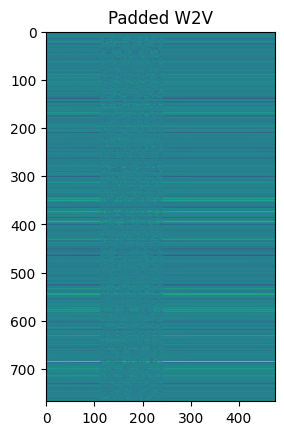

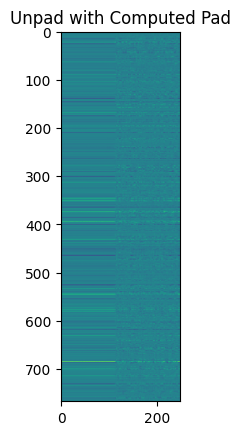

In [51]:
plt.title("Padded W2V")
plt.imshow(speaker_w2v_10[0].T)
plt.show()
plt.title("Unpad with Computed Pad")
plt.imshow(speaker_w2v_10[0][computed_w2v_pad[0]==1].T)
plt.show()

> <span style="color:red">**TODO**</span>: Explore [Wav2Vec2Model](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2Model) docs and use `attention_mask` in order to optimize computations and unpad seuqnce in a bettter way (0.5 point).

In [52]:
# Free memory 
del model, processor
torch.cuda.empty_cache()
gc.collect()

10156

## [Hubert](https://arxiv.org/abs/2106.07447)

Model, which is able to predict discrete speech representations.

Overall Pipeline:
1. Cluster MFCC audio representations.
2. Train Masked CNN->Transformer model to predict masked regions.

![hubert_concept](images/hubert_concept.png)

Main ideas:
- Clustered representations may correlate with phonemes.
- In order to “guess” masked regions model should understand audio structure.
- Deeper architecture compared to W2V, in order to create more "high level" audio representations.

![hubert_architecture](images/hubert_architecture.png)

After model is trained we can use HuBERT part to create self supervised audio representations.

![hubert_results](images/hubert_results.png)

Code example is adopted from official HF example:

- [ASR](https://huggingface.co/docs/transformers/model_doc/hubert#transformers.HubertForCTC).
- [SSL](https://huggingface.co/docs/transformers/model_doc/hubert#transformers.HubertModel).

In [54]:
processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft").to(DEVICE)

Some weights of the model checkpoint at facebook/hubert-large-ls960-ft were not used when initializing HubertForCTC: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForCTC were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-

In [55]:
parameter_counter(model, "Hubert")

Hubert Parameters Count: 315.5M


In [56]:
input_values = processor([
    el for el in speaker_audio_10_16k.numpy()
], sampling_rate=16_000, return_tensors="pt")

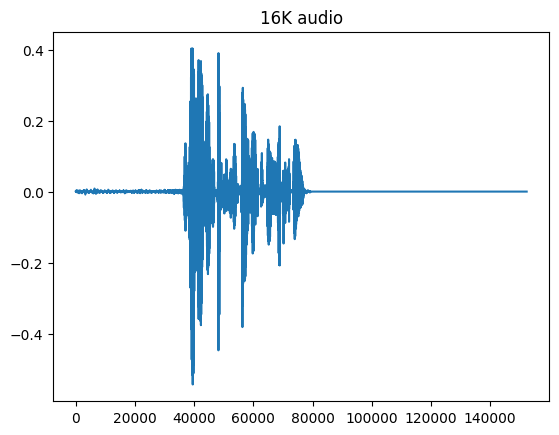

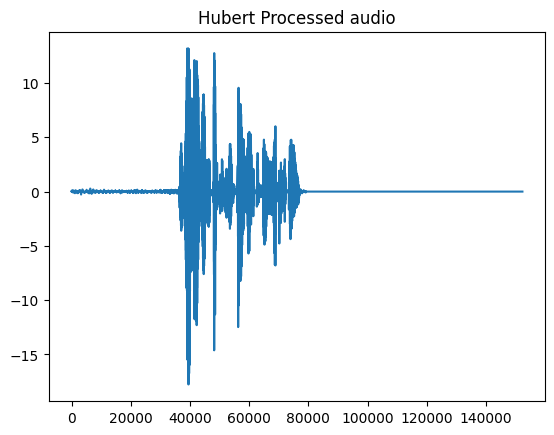

In [57]:
plt.title("16K audio")
plt.plot(speaker_audio_10_16k[0])
plt.show()
plt.title("Hubert Processed audio")
plt.plot(input_values.input_values[0])
plt.show()

In [58]:
with torch.no_grad():
    model_output = model(input_values.input_values.cuda())

In [59]:
print(f"Input Shape [B, L]: {input_values.input_values.shape}")
print(f"Ouput Shape [B, N_L, C]: {model_output.logits.shape}")

Input Shape [B, L]: torch.Size([10, 152317])
Ouput Shape [B, N_L, C]: torch.Size([10, 475, 32])


In [60]:
pred_ids = torch.argmax(model_output.logits[0], axis=-1)
transcription = processor.batch_decode(pred_ids)

In [61]:
transcription[:5]

['<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

In [62]:
" ".join([el for el in transcription if el!="<pad>"])

'T H E   G U Y D L I N E S   A R E  E X P E C T T E D D  T T O   B E   F I N N A L I Z E D  B E F O R E E    N N E X X T T   S S P R R I N G G   '

> <font style="color:red">**TODO**</font>: Check how to normalize outputs of [HubertForCTC](https://huggingface.co/docs/transformers/model_doc/hubert#transformers.HubertForCTC). *Simply put, make them in a format we had for W2V.* (2 points)

Overall, if we normalize Hubert outputs, we can see that (on this particular sample) it performs better:

- W2V: `GYDINES`, Hubert: `G U Y D L I N E S`, GT: `guidelines`.
- W2V: `FINE LINES`, Hubert: `F I N N A L I Z E D`, GT: `finalised`.

In [63]:
# Free memory 
del model, processor
torch.cuda.empty_cache()
gc.collect()

3579

In [64]:
processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft").to(DEVICE)

Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
input_values = processor([
    el for el in speaker_audio_10_16k.numpy()
], sampling_rate=16_000, return_tensors="pt")

In [66]:
with torch.no_grad():
    speaker_hubert_10 = model(input_values.input_values.cuda()).last_hidden_state.cpu()

In [67]:
speaker_hubert_10.shape

torch.Size([10, 475, 1024])

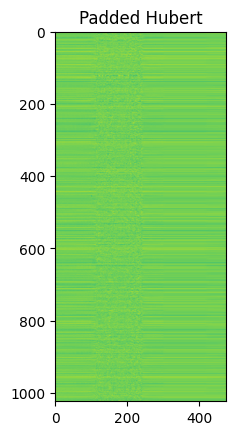

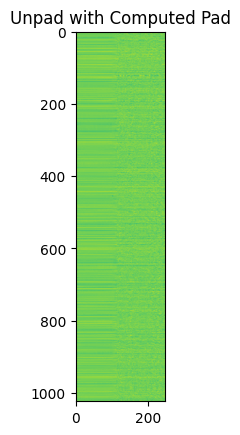

In [68]:
plt.title("Padded Hubert")
plt.imshow(speaker_hubert_10[0].T)
plt.show()
plt.title("Unpad with Computed Pad")
plt.imshow(speaker_hubert_10[0][computed_w2v_pad[0]==1].T)
plt.show()

In [69]:
# Free memory 
del model, processor
torch.cuda.empty_cache()
gc.collect()

6102

## [Data2Vec](https://arxiv.org/pdf/2202.03555.pdf)

Model is distilled to predict its own representations from previous updates, given a masked input

Pipeline:
1. Encode audio sample with the Teacher model.
2. Mask some sample content and encode it with the Student model.
3. Optimize the Student model, so it produces same representation as the Teacher model.
4. Update the Teacher model with Exponential Moving Average of Student's weights.

![d2v_concept](images/d2v_concept.png)

Main ideas:

- It is a kind of combination of Wave2Vec and Hubert ideas.
- Operates only on its own data representations.
- Representations “to predict” come from the transformer.

![d2v_loss](images/d2v_loss.png)

![d2v_results](images/d2v_results.png)

Code example is adopted from official HF example:

- [ASR](https://huggingface.co/docs/transformers/model_doc/data2vec#transformers.Data2VecAudioForCTC).
- [SSL](https://huggingface.co/docs/transformers/model_doc/data2vec#transformers.Data2VecAudioModel).

In [71]:
processor = AutoProcessor.from_pretrained("facebook/data2vec-audio-base-960h")
model = Data2VecAudioForCTC.from_pretrained("facebook/data2vec-audio-base-960h").to(DEVICE)

In [72]:
parameter_counter(model, "D2V")

D2V Parameters Count: 93.2M


In [73]:
input_values = processor([
    el for el in speaker_audio_10_16k.numpy()
], sampling_rate=16_000, return_tensors="pt")

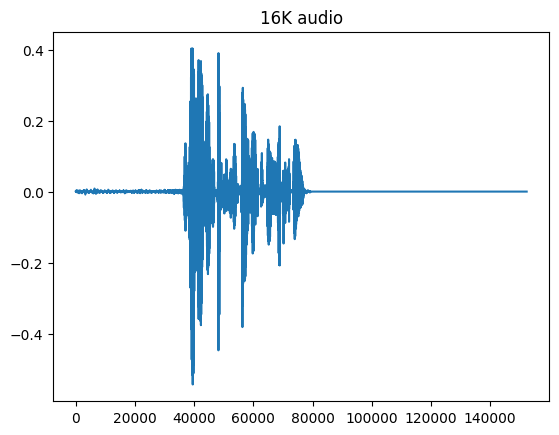

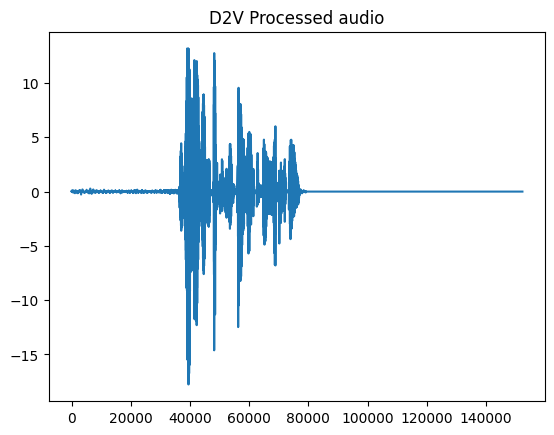

In [74]:
plt.title("16K audio")
plt.plot(speaker_audio_10_16k[0])
plt.show()
plt.title("D2V Processed audio")
plt.plot(input_values.input_values[0])
plt.show()

In [75]:
with torch.no_grad():
    model_output = model(input_values.input_values.cuda())

In [76]:
print(f"Input Shape [B, L]: {input_values.input_values.shape}")
print(f"Ouput Shape [B, N_L, C]: {model_output.logits.shape}")

Input Shape [B, L]: torch.Size([10, 152317])
Ouput Shape [B, N_L, C]: torch.Size([10, 475, 32])


In [77]:
pred_ids = torch.argmax(model_output.logits[0], axis=-1)
transcription = processor.batch_decode(pred_ids)

In [78]:
transcription[:5]

['<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

In [79]:
" ".join([el for el in transcription if el!="<pad>"])

'    T H E    G U Y L I N E S S  A R E   E X P E C T T E D   T O   B E   F I N E L I N E S S   B E F O R E       N E X T T  S P P R R I N N G    '

Overall, if we normalize D2V outputs, we can see that (on this particular sample) it performs the worst :) :

- W2V: `GYDINES`, Hubert: `G U Y D L I N E S`, D2V: `G U Y L I N E S S`, GT: `guidelines`
- W2V: `FINE LINES`, Hubert: `F I N N A L I Z E D`, D2V: `F I N E L I N E S S`, GT: `finalised`

In [80]:
# Free memory 
del model, processor
torch.cuda.empty_cache()
gc.collect()

3484

In [81]:
processor = AutoProcessor.from_pretrained("facebook/data2vec-audio-base-960h")
model = Data2VecAudioModel.from_pretrained("facebook/data2vec-audio-base-960h").to(DEVICE)

In [82]:
with torch.no_grad():
    speaker_d2v_10 = model(input_values.input_values.cuda()).last_hidden_state.cpu()

In [83]:
speaker_d2v_10.shape

torch.Size([10, 475, 768])

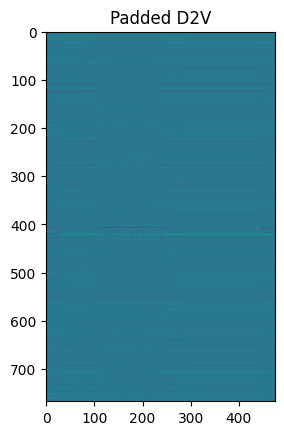

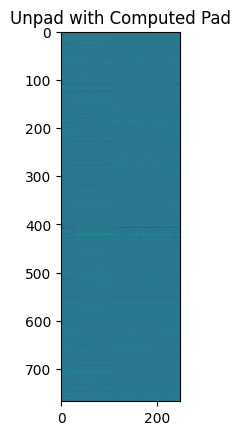

In [84]:
plt.title("Padded D2V")
plt.imshow(speaker_d2v_10[0].T)
plt.show()
plt.title("Unpad with Computed Pad")
plt.imshow(speaker_d2v_10[0][computed_w2v_pad[0]==1].T)
plt.show()

In [85]:
# Free memory 
del model, processor
torch.cuda.empty_cache()
gc.collect()

6623

## Hot to train SSL models ?

Code for training is adapted from [transformers examples](https://github.com/huggingface/transformers/tree/main/examples/pytorch/speech-pretraining)

In [3]:
import torch
from torch.utils.data import DataLoader
import math
import os
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import datasets
from datasets import load_dataset, concatenate_datasets, DatasetDict
from transformers import (
    AdamW,
    Wav2Vec2Config,
    Wav2Vec2FeatureExtractor,
    Wav2Vec2ForPreTraining,
    get_scheduler,
    set_seed
)
from transformers.models.wav2vec2.modeling_wav2vec2 import _compute_mask_indices, _sample_negative_indices

# Set up logging
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [60]:
class PretrainingConfig:
    def __init__(self):
        # Dataset parameters
        self.dataset_name = "librispeech_asr"
        self.dataset_config_names = ["clean", "clean"]
        self.dataset_split_names = ["validation", "test"]
        self.audio_column_name = "audio"
        self.max_duration_in_seconds = 20.0
        self.min_duration_in_seconds = 2.0
        self.validation_split_percentage = 1
        
        # Model parameters
        self.model_name_or_path = "patrickvonplaten/wav2vec2-base-v2"
        self.mask_time_prob = 0.65
        self.mask_time_length = 10
        self.gradient_checkpointing = True
        
        # Training parameters
        self.seed = 42
        self.train_batch_size = 2
        self.eval_batch_size = 2
        self.gradient_accumulation_steps = 8
        self.learning_rate = 1e-5
        self.adam_beta1 = 0.9
        self.adam_beta2 = 0.98
        self.adam_epsilon = 1e-06
        self.weight_decay = 0.01
        self.max_train_steps = 20000
        self.num_warmup_steps = 32000
        self.max_gumbel_temperature = 2.0
        self.min_gumbel_temperature = 0.5
        self.gumbel_temperature_decay = 0.999995
        self.pad_to_multiple_of = None
        
        # Output parameters
        self.output_dir = "./wav2vec2-pretrained-demo"
        self.logging_steps = 10
        self.saving_steps = 1000
        
        # Scheduler
        self.lr_scheduler_type = "linear"
        self.num_train_epochs = 5
        self.device = torch.device("cuda")

In [61]:
@dataclass
class DataCollatorForWav2Vec2Pretraining: # Copy from transformers/examples/pytorch/speech-pretraining/run_wav2vec2_pretraining_no_trainer.py
    model: Wav2Vec2ForPreTraining
    feature_extractor: Wav2Vec2FeatureExtractor
    padding: Union[bool, str] = "longest"
    pad_to_multiple_of: Optional[int] = None
    mask_time_prob: Optional[float] = 0.65
    mask_time_length: Optional[int] = 10
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # reformat list to dict and set to pytorch format
        batch = self.feature_extractor.pad(
            features,
            padding=self.padding,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",

        )
        
        device = next(self.model.parameters()).device
        batch = {k: v.to(device) for k, v in batch.items()}

        batch_size = batch["input_values"].shape[0]

        mask_indices_seq_length = self.model._get_feat_extract_output_lengths(batch["input_values"].shape[-1])
        # make sure masked sequence length is a Python scalar
        mask_indices_seq_length = int(mask_indices_seq_length)

        # make sure that no loss is computed on padded inputs
        if batch.get("attention_mask") is not None:
            # compute real output lengths according to convolution formula
            batch["sub_attention_mask"] = self.model._get_feature_vector_attention_mask(
                mask_indices_seq_length, batch["attention_mask"]
            )

        features_shape = (batch_size, mask_indices_seq_length)

        # sample randomly masked indices
        mask_time_indices = _compute_mask_indices(
            features_shape,
            self.mask_time_prob,
            self.mask_time_length,
            attention_mask=batch.get("sub_attention_mask"),
        )

        # sample negative indices
        sampled_negative_indices = _sample_negative_indices(
            features_shape,
            self.model.config.num_negatives,
            mask_time_indices=mask_time_indices,
        )
        batch["mask_time_indices"] = torch.tensor(mask_time_indices, dtype=torch.long, device=device)
        batch["sampled_negative_indices"] = torch.tensor(sampled_negative_indices, dtype=torch.long, device=device)

        return batch

def multiply_grads(params, c):
    for p in params:
        if p.grad is not None:
            if torch.is_tensor(c):
                c = c.to(p.grad.device)
            p.grad.data.mul_(c)


def get_grad_norm(params, scale=1):
    total_norm = 0.0
    for p in params:
        if p.grad is not None:
            param_norm = (p.grad.detach().data / scale).norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm**0.5
    return total_norm

In [62]:
def prepare_datasets(config):
    datasets_splits = []
    for dataset_config_name, split_name in zip(config.dataset_config_names, config.dataset_split_names):
        print(split_name, dataset_config_name)
        dataset_split = load_dataset(
            config.dataset_name,
            dataset_config_name,
            split=split_name,
        )
        datasets_splits.append(dataset_split)

    raw_datasets = DatasetDict()
    if len(datasets_splits) > 1:
        raw_datasets["train"] = concatenate_datasets(datasets_splits).shuffle(seed=config.seed)
    else:
        raw_datasets["train"] = datasets_splits[0]

    # Create validation split
    num_validation_samples = raw_datasets["train"].num_rows * config.validation_split_percentage // 100
    if num_validation_samples == 0:
        raise ValueError(
            f"Validation split percentage is too small for {len(raw_datasets['train'])} training samples."
        )

    raw_datasets["validation"] = raw_datasets["train"].select(range(num_validation_samples))
    raw_datasets["train"] = raw_datasets["train"].select(range(num_validation_samples, raw_datasets["train"].num_rows))

    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(config.model_name_or_path)

    # Ensure dataset has the correct sampling rate
    raw_datasets = raw_datasets.cast_column(
        config.audio_column_name, datasets.features.Audio(sampling_rate=feature_extractor.sampling_rate)
    )

    max_length = int(config.max_duration_in_seconds * feature_extractor.sampling_rate)
    min_length = int(config.min_duration_in_seconds * feature_extractor.sampling_rate)

    def prepare_dataset(batch):
        sample = batch[config.audio_column_name]
        inputs = feature_extractor(
            sample["array"], sampling_rate=sample["sampling_rate"], max_length=max_length, truncation=True
        )
        batch["input_values"] = inputs.input_values[0]
        batch["input_length"] = len(inputs.input_values[0])
        return batch

    print("Processing datasets...")
    vectorized_datasets = raw_datasets.map(
        prepare_dataset,
        remove_columns=raw_datasets["train"].column_names,
    )

    # Filter by minimum length
    if min_length > 0:
        vectorized_datasets = vectorized_datasets.filter(
            lambda x: x > min_length,
            input_columns=["input_length"],
        )

    vectorized_datasets = vectorized_datasets.remove_columns("input_length")
    
    print(f"Training dataset size: {len(vectorized_datasets['train'])}")
    print(f"Validation dataset size: {len(vectorized_datasets['validation'])}")
    
    return vectorized_datasets, feature_extractor

In [63]:
def setup_model_and_training(config, vectorized_datasets, feature_extractor):
    # Load model config
    model_config = Wav2Vec2Config.from_pretrained(config.model_name_or_path)
    
    # Check if config is compatible with pretraining
    if not model_config.do_stable_layer_norm or model_config.feat_extract_norm != "layer":
        raise ValueError(
            "PreTraining requires config.do_stable_layer_norm=True and config.feat_extract_norm='layer'"
        )
    
    model = Wav2Vec2ForPreTraining(model_config)
    model = model.to(config.device)
    
    if config.gradient_checkpointing:
        model.gradient_checkpointing_enable()
    
    mask_time_prob = model_config.mask_time_prob if config.mask_time_prob is None else config.mask_time_prob
    mask_time_length = model_config.mask_time_length if config.mask_time_length is None else config.mask_time_length
    
    data_collator = DataCollatorForWav2Vec2Pretraining(
        model=model,
        feature_extractor=feature_extractor,
        pad_to_multiple_of=config.pad_to_multiple_of,
        mask_time_prob=mask_time_prob,
        mask_time_length=mask_time_length,
    )
    
    train_dataloader = DataLoader(
        vectorized_datasets["train"],
        shuffle=True,
        collate_fn=data_collator,
        batch_size=config.train_batch_size,
    )
    
    eval_dataloader = DataLoader(
        vectorized_datasets["validation"],
        collate_fn=data_collator,
        batch_size=config.eval_batch_size,
    )
    
    optimizer = AdamW(
        list(model.parameters()),
        lr=config.learning_rate,
        betas=[config.adam_beta1, config.adam_beta2],
        eps=config.adam_epsilon,
        weight_decay=config.weight_decay,
    )
    
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / config.gradient_accumulation_steps)
    
    if config.max_train_steps is None:
        config.max_train_steps = config.num_train_epochs * num_update_steps_per_epoch
    
    lr_scheduler = get_scheduler(
        name=config.lr_scheduler_type,
        optimizer=optimizer,
        num_warmup_steps=config.num_warmup_steps,
        num_training_steps=config.max_train_steps,
    )
    
    config.num_train_epochs = math.ceil(config.max_train_steps / num_update_steps_per_epoch)
    
    return model, optimizer, lr_scheduler, train_dataloader, eval_dataloader, num_update_steps_per_epoch

In [64]:
def init_training():
    config = PretrainingConfig()
    
    set_seed(config.seed)
    vectorized_datasets, feature_extractor = prepare_datasets(config)
    
    model, optimizer, lr_scheduler, train_dataloader, eval_dataloader, num_update_steps_per_epoch = setup_model_and_training(
        config, vectorized_datasets, feature_extractor
    )
    
    os.makedirs(config.output_dir, exist_ok=True)
    return config, model, optimizer, lr_scheduler, train_dataloader, eval_dataloader, num_update_steps_per_epoch

In [ ]:
config, model, optimizer, lr_scheduler, train_dataloader, eval_dataloader, num_update_steps_per_epoch = init_training()

completed_steps = 0
train_losses = []
val_losses = []
learning_rates = []

progress_bar = tqdm(range(config.max_train_steps), desc="Training")

# Main training loop
for epoch in range(config.num_train_epochs):
    model.train()
    epoch_loss = 0
    
    epoch_progress = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{config.num_train_epochs}", leave=False)
    
    for step, batch in enumerate(epoch_progress):
        num_losses = batch["mask_time_indices"].sum()
        sub_attention_mask = batch.pop("sub_attention_mask", None)
        if sub_attention_mask is None:
            sub_attention_mask = torch.ones_like(batch["mask_time_indices"])
        percent_masked = num_losses / sub_attention_mask.sum()
        
        outputs = model(**batch)
        
        loss = outputs.loss / config.gradient_accumulation_steps
        epoch_loss += loss.item()
        
        loss.backward()
        multiply_grads(model.parameters(), 1 / num_losses)
        
        if (step + 1) % config.gradient_accumulation_steps == 0 or step == len(train_dataloader) - 1:
            grad_norm = get_grad_norm(model.parameters())
            
            optimizer.step()
            optimizer.zero_grad()
            
            lr_scheduler.step()
            
            gumbel_temperature = max(
                config.max_gumbel_temperature * config.gumbel_temperature_decay**completed_steps,
                config.min_gumbel_temperature,
            )
            model.set_gumbel_temperature(gumbel_temperature)
            
            progress_bar.update(1)
            completed_steps += 1
            
            learning_rates.append(optimizer.param_groups[0]["lr"])
        
        if (step + 1) % (config.gradient_accumulation_steps * config.logging_steps) == 0:
            loss_value = loss.item() * config.gradient_accumulation_steps
            
            train_losses.append(loss_value)
            
            log_dict = {
                "loss": loss_value,
                "contrast_loss": outputs.contrastive_loss.item() / num_losses.item(),
                "div_loss": outputs.diversity_loss.item() / num_losses.item(),
                "mask_percent": percent_masked.item(),
                "perplexity": outputs.codevector_perplexity.item(),
                "lr": optimizer.param_groups[0]["lr"],
                "temp": gumbel_temperature,
                "grad_norm": grad_norm,
            }
            
            epoch_progress.set_postfix(**{k: f"{v:.4f}" for k, v in log_dict.items() if k in ["loss", "lr"]})
            
            log_str = f"Step: {completed_steps}/{config.max_train_steps}"
            for k, v in log_dict.items():
                log_str += f" | {k}: {v:.4f}"
            logger.info(log_str)
        
        if (step + 1) % (config.gradient_accumulation_steps * config.saving_steps) == 0:
            output_checkpoint_dir = os.path.join(config.output_dir, f"checkpoint-{completed_steps}")
            os.makedirs(output_checkpoint_dir, exist_ok=True)
            
            model.save_pretrained(output_checkpoint_dir)
            logger.info(f"Saved checkpoint to {output_checkpoint_dir}")
        
        if completed_steps >= config.max_train_steps:
            break
    
    model.eval()
    val_loss = 0.0
    val_contrastive_loss = 0.0
    val_diversity_loss = 0.0
    val_num_losses = 0
    
    logger.info("Running validation...")
    for batch in tqdm(eval_dataloader, desc="Validation", leave=False):
        with torch.no_grad():
            batch.pop("sub_attention_mask", None)
            outputs = model(**batch)
        
        val_loss += outputs.loss.item()
        val_contrastive_loss += outputs.contrastive_loss.item()
        val_diversity_loss += outputs.diversity_loss.item()
        val_num_losses += batch["mask_time_indices"].sum().item()
    
    avg_val_loss = val_loss / val_num_losses
    val_losses.append(avg_val_loss)
    
    logger.info(f"Validation results - Epoch {epoch+1}/{config.num_train_epochs}:")
    logger.info(f"  Loss: {avg_val_loss:.4f}")
    logger.info(f"  Contrastive loss: {val_contrastive_loss / val_num_losses:.4f}")
    logger.info(f"  Diversity loss: {val_diversity_loss / val_num_losses:.4f}")
    
#    if (epoch + 1) % 2 == 0 or epoch == config.num_train_epochs - 1:
#        plot_training_metrics(train_losses, val_losses, learning_rates)

model.save_pretrained(config.output_dir)
logger.info(f"Training completed! Final model saved to {config.output_dir}")

# plot_training_metrics(train_losses, val_losses, learning_rates)

trained_model = model
metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "learning_rates": learning_rates
}

validation clean


/home/yuriiyelisieiev/Developer/lectures/ucu_audio_processing_course/.venv/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for librispeech_asr contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/librispeech_asr
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


test clean
Processing datasets...


Map:   0%|          | 0/5270 [00:00<?, ? examples/s]

Map:   0%|          | 0/53 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5270 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53 [00:00<?, ? examples/s]

Training dataset size: 5194
Validation dataset size: 53


/home/yuriiyelisieiev/Developer/lectures/ucu_audio_processing_course/.venv/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1/62:   0%|          | 0/2597 [00:00<?, ?it/s]

INFO:__main__:Step: 10/20000 | loss: 591.3173 | contrast_loss: 4.6358 | div_loss: 0.9469 | mask_percent: 0.5020 | perplexity: 33.9920 | lr: 0.0000 | temp: 1.9999 | grad_norm: 0.4003
INFO:__main__:Step: 20/20000 | loss: 776.2964 | contrast_loss: 4.5807 | div_loss: 0.9581 | mask_percent: 0.5646 | perplexity: 26.8360 | lr: 0.0000 | temp: 1.9998 | grad_norm: 0.3298
INFO:__main__:Step: 30/20000 | loss: 2421.0149 | contrast_loss: 4.6060 | div_loss: 0.9499 | mask_percent: 0.4877 | perplexity: 32.0424 | lr: 0.0000 | temp: 1.9997 | grad_norm: 0.2872
INFO:__main__:Step: 40/20000 | loss: 1047.9154 | contrast_loss: 4.5610 | div_loss: 0.9643 | mask_percent: 0.4967 | perplexity: 22.8493 | lr: 0.0000 | temp: 1.9996 | grad_norm: 0.3224
INFO:__main__:Step: 50/20000 | loss: 1132.8392 | contrast_loss: 4.6248 | div_loss: 0.9533 | mask_percent: 0.4528 | perplexity: 29.8685 | lr: 0.0000 | temp: 1.9995 | grad_norm: 0.3502
INFO:__main__:Step: 60/20000 | loss: 1034.1246 | contrast_loss: 4.6051 | div_loss: 0.95

KeyboardInterrupt: 

## How to benchmark SSL models ?

The most popular approach is [SUPERB: Speech processing Universal PERformance Benchmark](https://arxiv.org/abs/2105.01051).

Using this benchmark, we evaluate SSL models (SSL Model -> "Head") on the following tasks:

- Phoneme Recognition, PR.
- Automatic Speech Recognition, ASR.
- Keyword Spotting, KS.
- Query by Example Spoken Term Detection, QbE.
- Speaker Identification, SID.
- Automatic Speaker Verification, ASV.
- Speaker Diarization, SD.
- Intent Classification, IC.
- Slot Filling, SF.
- Emotion Recognition, ER.

Explore best models on interactive [Leaderboard](https://superbbenchmark.org/leaderboard).

## One interesting common thing with all these models

`facebook/...`

[Yann LeCun On How An Open Source Approach Could Shape AI](https://www.time.com/6691705/time100-impact-awards-yann-lecun/)

![Yann_LeCun](images/Yann_LeCun.png)

<a id='SSL_Features_for_Speaker_Classification'></a>
# SSL Features for Speaker Classification

## Prepare Data

In [86]:
# Created by ChatGPT: https://chat.openai.com/share/e/0fe06227-eedf-4228-8845-48152d32d4a7
def read_file_content(file_path):
    """
    Reads the content of a text file and returns it as a string.

    Parameters:
    file_path (str): The path to the .txt file to be read.

    Returns:
    str: The content of the file as a string.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read().rstrip('\n')
        return content
    except FileNotFoundError:
        return None
    except Exception as e:
        return f"An error occurred: {e}"


In [87]:
vctk_df  = pd.DataFrame({
    "filename": wave_pathes
})

In [88]:
vctk_df.filename.iloc[0]

'../../data/VCTK-Corpus/VCTK-Corpus/wav48/p225/p225_001.wav'

In [89]:
vctk_df["speaker"] = vctk_df["filename"].apply(lambda x: int(x.split("/")[-2][1:]))
vctk_df["text_id"] = vctk_df["filename"].apply(lambda x: int(os.path.splitext(os.path.basename(x))[0].split("_")[1]))

In [90]:
vctk_df["text"] = vctk_df["filename"].apply(lambda x: read_file_content(x.replace("wav48", "txt").replace(".wav",".txt")))

In [91]:
vctk_df.groupby("text_id")["text"].apply(set).iloc[5]

{'"When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow. "',
 None,
 'When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow.',
 'When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow. ',
 'When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow. )',
 'When the sunlight strikes the raindrops in the air, they act as a prism and form a rainbow.'}

In [92]:
unique_text = len(set(vctk_df["text_id"]))
print("Unique texts:", unique_text)

Unique texts: 503


In [93]:
test_text_id = sorted(set(vctk_df["text_id"]))[-150:]
test_text_id[:10]

[354, 355, 356, 357, 358, 359, 360, 361, 362, 363]

In [78]:
# train_df, test_df = (
#     vctk_df[~vctk_df["text_id"].isin(test_text_id)].reset_index(drop=True), 
#     vctk_df[vctk_df["text_id"].isin(test_text_id)].reset_index(drop=True)
# )

In [95]:
# # Uncomment it to download
# !kaggle datasets download -d vladimirsydor/vctk-xvectors
# !unzip vctk-xvectors.zip -d ../../data/vctk_xvectors
# # Correct next pathes 

In [96]:
# train_df.to_csv("../../data/vctk_ssl_features/train.csv", index=False)
# test_df.to_csv("../../data/vctk_ssl_features/test.csv", index=False)

In [97]:
train_df = pd.read_csv("../../data/vctk_xvectors/train.csv")
test_df = pd.read_csv("../../data/vctk_xvectors/test.csv")

In [98]:
assert not set(train_df["text_id"]) & set(test_df["text_id"])

In [99]:
print("Speakers 'missing' in train set", set(test_df["speaker"]) - set(train_df["speaker"]))
print("Speakers 'missing' in test set", set(train_df["speaker"]) -  set(test_df["speaker"]))

Speakers 'missing' in train set set()
Speakers 'missing' in test set {256, 265, 364, 237, 302, 303, 376}


In [100]:
print( 
    (vctk_df[vctk_df["text_id"].isin(test_text_id)].shape[0] / vctk_df.shape[0]) * 100,
    "% of samples in test",
)

15.112336693639527 % of samples in test


In [101]:
train_df["speaker"].value_counts()

speaker
248    353
360    353
301    353
239    353
329    353
      ... 
302    311
364    301
376    292
225    222
315    151
Name: count, Length: 109, dtype: int64

In [102]:
test_df["speaker"].value_counts()

speaker
236    150
239    150
264    141
250    141
259    128
      ... 
306      7
246      7
245      6
260      4
249      1
Name: count, Length: 102, dtype: int64

In [103]:
target_label_encoder = LabelEncoder().fit(train_df["speaker"])
train_y = target_label_encoder.transform(train_df["speaker"])
test_y = target_label_encoder.transform(test_df["speaker"])

In [104]:
train_y

array([29, 29, 29, ...,  2,  2,  2])

In [105]:
test_y

array([73, 73, 73, ...,  2,  2,  2])

## Naive Baselines

In [106]:
def compute_score(
    y_true,
    y_pred
):
    print("accuracy", accuracy_score(y_true, y_pred))
    print("f1", f1_score(y_true, y_pred, average="micro"))

In [107]:
train_random_predict = np.random.randint(low=train_y.min(), high=train_y.max() + 1, size=train_y.shape)
test_random_predict = np.random.randint(low=train_y.min(), high=train_y.max() + 1, size=test_y.shape)

In [108]:
print("Train Random Scores")
compute_score(train_y, train_random_predict)
print("Test Random Scores")
compute_score(test_y, test_random_predict)

Train Random Scores
accuracy 0.008334220896794121
f1 0.008334220896794121
Test Random Scores
accuracy 0.008824409213281485
f1 0.008824409213281485


In [109]:
def find_most_frequent_element(arr):
    """
    Finds and returns the most frequent element in the given numpy array.

    Parameters:
    arr (numpy.ndarray): The input numpy array.

    Returns:
    int or float: The most frequent element in the array.
    """
    # Find unique elements and their counts
    unique_elements, counts = np.unique(arr, return_counts=True)

    # Find the index of the element with the highest count
    max_count_index = np.argmax(counts)

    # The most frequent element
    most_frequent_element = unique_elements[max_count_index]

    return most_frequent_element

In [110]:
train_most_popular_predict = np.full_like(train_y, find_most_frequent_element(train_y))
test_most_popular_predict = np.full_like(test_y, find_most_frequent_element(test_y))

In [111]:
print("Train Most Popular Scores")
compute_score(train_y, train_most_popular_predict)
print("Test Most Popular Scores")
compute_score(test_y, test_most_popular_predict)

Train Most Popular Scores
accuracy 0.009399297049739056
f1 0.009399297049739056
Test Most Popular Scores
accuracy 0.02243493867783428
f1 0.02243493867783428


## Compute features Class

In [112]:
class XVectorExtractor:
    def __init__(
        self,
        model_name,
        device="cpu",
        do_normalize=True
    ):
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        self.model = AutoModelForAudioXVector.from_pretrained(model_name).to(device)
        self.do_normalize = do_normalize

    def extract_features(
        self,
        wave_pathes,
        sample_rate
    ):
        features = []
        for wave_path in tqdm(wave_pathes):
            wave, _ = librosa.load(wave_path, sr=sample_rate)
            inputs = self.feature_extractor([wave], sampling_rate=sample_rate, return_tensors="pt").input_values
            with torch.no_grad():
                embeddings = self.model(inputs.cuda()).embeddings
            if self.do_normalize:
                embeddings = torch.nn.functional.normalize(embeddings, dim=-1)
            embeddings = embeddings.cpu()
            features.append(embeddings)
        return torch.cat(features, dim=0)

> <font style="color:red">**TODO**</font>: Add batching (1 point).

> <font style="color:red">**TODO**</font>: How to transform `Wav2Vec2Model` into `Wav2Vec2ForXVector` (0.5 point)?

## W2V 2.0

Explore what is new compared to W2V in [paper](https://arxiv.org/abs/2006.11477).

In [140]:
w2v2_xvector_model = XVectorExtractor(
    model_name="anton-l/wav2vec2-base-superb-sv",
    device="cuda",
    do_normalize=True
)

Some weights of the model checkpoint at anton-l/wav2vec2-base-superb-sv were not used when initializing Wav2Vec2ForXVector: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForXVector from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForXVector from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForXVector were not initialized from the model checkpoint at anton-l/wav2vec2-base-superb-sv and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should pr

In [141]:
w2v2_xvector_model.extract_features(train_df.filename.iloc[:2], sample_rate=16_000)

100%|██████████| 2/2 [00:00<00:00, 82.39it/s]


tensor([[-0.0137, -0.0238, -0.0223,  ..., -0.0190, -0.0230, -0.0218],
        [-0.0140, -0.0213, -0.0178,  ..., -0.0177, -0.0237, -0.0208]])

In [142]:
# train_w2v2_embs = w2v2_xvector_model.extract_features(
#     train_df.filename.to_list(), 
#     sample_rate=16_000
# )
# test_w2v2_embs = w2v2_xvector_model.extract_features(
#     test_df.filename.to_list(), 
#     sample_rate=16_000
# )

In [143]:
# np.save("../../data/vctk_ssl_features/w2v2_train_xvectors.npy", train_w2v2_embs.numpy())
# np.save("../../data/vctk_ssl_features/w2v2_test_xvectors.npy", test_w2v2_embs.numpy())

In [144]:
train_w2v2_embs = np.load("../../data/vctk_xvectors/w2v2_train_xvectors.npy")
test_w2v2_embs = np.load("../../data/vctk_xvectors/w2v2_test_xvectors.npy")

In [145]:
classification_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])

In [146]:
classification_pipeline.fit(train_w2v2_embs, train_y)

Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

In [147]:
train_w2v2_predict = classification_pipeline.predict(train_w2v2_embs)
test_w2v2_predict = classification_pipeline.predict(test_w2v2_embs)

In [148]:
print("Train W2V Scores")
compute_score(train_y, train_w2v2_predict)
print("Test W2V Scores")
compute_score(test_y, test_w2v2_predict)

Train W2V Scores
accuracy 1.0
f1 1.0
Test W2V Scores
accuracy 0.9156446305713432
f1 0.9156446305713432


In [149]:
# Free memory 
del w2v2_xvector_model
torch.cuda.empty_cache()
gc.collect()

306

## D2V

In [150]:
d2v_xvector_model = XVectorExtractor(
    model_name="facebook/data2vec-audio-base-960h",
    device="cuda",
    do_normalize=True
)

Some weights of Data2VecAudioForXVector were not initialized from the model checkpoint at facebook/data2vec-audio-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'feature_extractor.bias', 'feature_extractor.weight', 'objective.weight', 'projector.bias', 'projector.weight', 'tdnn.0.kernel.bias', 'tdnn.0.kernel.weight', 'tdnn.1.kernel.bias', 'tdnn.1.kernel.weight', 'tdnn.2.kernel.bias', 'tdnn.2.kernel.weight', 'tdnn.3.kernel.bias', 'tdnn.3.kernel.weight', 'tdnn.4.kernel.bias', 'tdnn.4.kernel.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [151]:
# train_d2v_embs = d2v_xvector_model.extract_features(
#     train_df.filename.to_list(), 
#     sample_rate=16_000
# )
# test_d2v_embs = d2v_xvector_model.extract_features(
#     test_df.filename.to_list(), 
#     sample_rate=16_000
# )

In [152]:
# np.save("../../data/vctk_ssl_features/d2v_train_xvectors.npy", train_d2v_embs.numpy())
# np.save("../../data/vctk_ssl_features/d2v_test_xvectors.npy", test_d2v_embs.numpy())

In [153]:
train_d2v_embs = np.load("../../data/vctk_xvectors/d2v_train_xvectors.npy")
test_d2v_embs = np.load("../../data/vctk_xvectors/d2v_test_xvectors.npy")

In [154]:
classification_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])

In [155]:
classification_pipeline.fit(train_d2v_embs, train_y)

/home/yuriiyelisieiev/Developer/lectures/ucu_audio_processing_course/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

In [156]:
train_d2v_predict = classification_pipeline.predict(train_d2v_embs)
test_d2v_predict = classification_pipeline.predict(test_d2v_embs)

In [157]:
print("Train D2V Scores")
compute_score(train_y, train_d2v_predict)
print("Test D2V Scores")
compute_score(test_y, test_d2v_predict)

Train D2V Scores
accuracy 0.5886143359250187
f1 0.5886143359250187
Test D2V Scores
accuracy 0.25964702363146874
f1 0.25964702363146874


<a id='Homework'></a>
# Homework

Theory (8 points):
- Follow links.
- Try to fill/do **TODO** comments.
- Answer theory questions in the Google Form.

Practice (10 points):

#### Option 1 - Phoneme Recognition (PR)
Implement PR model using SSL features.

1. Take [TIMIT Dataset](https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech).
2. Build model based on SSL features:
    - Try several SSL models — you can take models from lecture or/and explore [HF Model Hub](https://huggingface.co/models) or/and explore [Superb Leaderboard](https://superbbenchmark.org/leaderboard).
    - In lecture we have used `last_hidden_state`. Experiment with other layers, as an example check [Hubert/4 Experimental Details/C](https://arxiv.org/abs/2106.07447).
    - Experiment with different "Heads": Linear, MLP, Recurrent (GRU, LSTM), Conv, Attention. DO NOT use "too Deep" heads.
3. Use PER (Phonem Error Rate) for evaluation. Use pre-defined train/test split.

Example: https://www.kaggle.com/code/vladimirsydor/phoneme-recognition-with-wav2vec2.

#### Option 2 - Automatic Speech Recognition (ASR)
Implement ASR modle using SSLF features.

1. Take [OpenTTS UK dataset](https://huggingface.co/datasets/Yehor/opentts-uk)
2. Check **Option 1 description**
3. Evaluate model on [Common Voice 10 Test set](https://github.com/egorsmkv/cv10-uk-testset-clean). Use WER (Word Error Rate) and Character Error Rate (CER) for evaluation.

<a id='Optional_Additional_Task'></a>
# Optional Additional Task

**10 Points**

Voice Conversion based on:
- SSL features.
- KNN (K Nearest Neighbors).
- Vocoding from SSL features.

Resources:
- [Code](https://arxiv.org/abs/2305.18975).
- [Paper](https://github.com/bshall/knn-vc).

Apply the proposed approach using another SSL features (they have used WavLM):

- Try 2-3 another SSL features and different layers.
- Do Voice Conversion on VCTK.
- Train Vocoder on LIBRISPEECH or/and VCTK.
- Compare results with paper results. 